### Modules:

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE 

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline as PipelineImblearn, make_pipeline as make_pipeline_imblearn

from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import f1_score, confusion_matrix

from utils import edit_df  # used just for table visualizations

SEED = 42

In [3]:
df = pd.read_csv("data/cleaned_MFCCs.csv")
X = df.drop(columns="Family")
y = df["Family"]

### GridSearch Arguments

In [4]:
gargs={"cv":8, "scoring": "f1_macro", "n_jobs": -1, "verbose": 3}

## Decision Tree

In [5]:
X = np.array(X, dtype=np.float32)  # required for tree optimization

    No rebalancing

In [6]:
dt_grid = {
    "pca__n_components": [8, 11, 16, 22],
    "dt__criterion": ["gini", "entropy"],
    "dt__class_weight": ["balanced"],
    "dt__ccp_alpha": [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
}

dt_pipeline = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("pca", PCA()),
        ("dt", DecisionTreeClassifier())
    ],
    memory="tmp"
)

dt_gridsearch = GridSearchCV(dt_pipeline, dt_grid, **gargs)
dt_gridsearch.fit(X, y)

Fitting 8 folds for each of 56 candidates, totalling 448 fits


GridSearchCV(cv=8,
             estimator=Pipeline(memory='tmp',
                                steps=[('scaler', RobustScaler()),
                                       ('pca', PCA()),
                                       ('dt', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'dt__ccp_alpha': [0, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                                           0.1],
                         'dt__class_weight': ['balanced'],
                         'dt__criterion': ['gini', 'entropy'],
                         'pca__n_components': [8, 11, 16, 22]},
             scoring='f1_macro', verbose=3)

In [8]:
# sorted by score_* = score_mean - score_std
dt_results = pd.DataFrame(dt_gridsearch.cv_results_)
edit_df(dt_results, classifier="tree").head(15).round(3)

dt__ccp_alpha  c_weight tree:crit n_pc  score_0  score_1  score_2  score_3  \
19         1e-05  balanced      gini   22    0.495    0.842    0.963    0.892   
11         1e-06  balanced      gini   22    0.469    0.828    0.958    0.892   
18         1e-05  balanced      gini   16    0.459    0.818    0.952    0.899   
2              0  balanced      gini   16    0.464    0.828    0.955    0.858   
3              0  balanced      gini   22    0.442    0.856    0.953    0.896   
35         0.001  balanced      gini   22    0.521    0.818    0.937    0.901   
34         0.001  balanced      gini   16    0.522    0.828    0.937    0.901   
16         1e-05  balanced      gini    8    0.477    0.897    0.947    0.914   
17         1e-05  balanced      gini   11    0.449    0.849    0.957    0.894   
9          1e-06  balanced      gini   11    0.403    0.851    0.957    0.888   
29        0.0001  balanced   entropy   11    0.389    0.860    0.968    0.940   
8          1e-06  balanced      gini    8    0.469    0.863    0.913    0.911   
6              0  balanced   entropy   16    0.353    0.864    0.958    0.958   
30        0.0001  balanced   entropy   16    0.354    0.846    0.948    0.953   
24        0.0001  balanced      gini    8    0.448    0.878    0.936    0.907   

    score_4  score_5  score_6  score_7  score_m  score_s  rank  score_*  
19    0.925    0.929    0.984    0.594    0.828    0.170     3    0.658  
11    0.904    0.929    0.978    0.595    0.819    0.174    15    0.645  
18    0.915    0.924    0.982    0.604    0.819    0.176    14    0.644  
2     0.939    0.929    0.984    0.593    0.819    0.177    18    0.642  
3     0.924    0.924    0.983    0.593    0.821    0.183     7    0.639  
35    0.894    0.897    0.978    0.521    0.808    0.171    35    0.637  
34    0.907    0.894    0.981    0.512    0.810    0.174    31    0.636  
16    0.922    0.976    0.994    0.498    0.828    0.199     2    0.629  
17    0.911    0.977    0.968    0.545    0.819    0.191    16    0.627  
9     0.920    0.975    0.974    0.604    0.821    0.195     8    0.627  
29    0.950    0.967    0.993    0.587    0.832    0.208     1    0.624  
8     0.921    0.978    0.995    0.500    0.819    0.197    17    0.622  
6     0.952    0.915    0.974    0.628    0.825    0.208     5    0.618  
30    0.939    0.916    0.974    0.632    0.820    0.204    11    0.616  
24    0.924    0.973    0.995    0.494    0.819    0.204    12    0.615

In [9]:
fig, ax = plt.subplots()
ax.errorbar([1], [0.828], yerr=[0.170], fmt='o', linewidth=2, capsize=6, label="best mean-std")
ax.errorbar([2], [0.832], yerr=[0.208], fmt='o', linewidth=2, capsize=6, label="best mean score")
ax.set(xlim=(0, 3), ylim=(0.5, 1));
ax.legend(loc="lower right");

    with SMOTe parameters

In [10]:
dtb_grid = {
    "smote__sampling_strategy": 
        [
            {"Bufonidae": 640},
            {"Bufonidae": 640, "Dendrobatidae": 1000, "Hylidae": 3000},
            "not majority"
        ],
    "pca__n_components": [8, 11, 16, 22],
    "dt__criterion": ["gini", "entropy"],
    "dt__class_weight": ["balanced"],
    "dt__ccp_alpha": [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
}

    SMOTe before PCA 

In [11]:
dtbb_pipeline = PipelineImblearn(
    [
        ("smote", SMOTE(random_state=SEED, n_jobs=-1)),
        ("scaler", RobustScaler()),
        ("pca", PCA()),
        ("dt", DecisionTreeClassifier())
    ],
    memory="tmp"
)

dtbb_gridsearch = GridSearchCV(dtbb_pipeline, dtb_grid, **gargs)
dtbb_gridsearch.fit(X, y);

Fitting 8 folds for each of 168 candidates, totalling 1344 fits


In [12]:
# choose best estimator: biggest score_mean - score_std
dtbb_results = pd.DataFrame(dtbb_gridsearch.cv_results_)
edit_df(dtbb_results, classifier="dt", using_smote=True).head(10).round(3)

dt__ccp_alpha  c_weight tree:crit n_pc  \
81        0.0001  balanced      gini   22   
33         1e-06  balanced      gini   22   
57         1e-05  balanced      gini   22   
9              0  balanced      gini   22   
84        0.0001  balanced   entropy    8   
36         1e-06  balanced   entropy    8   
52         1e-05  balanced      gini   11   
88        0.0001  balanced   entropy   11   
7              0  balanced      gini   16   
6              0  balanced      gini   16   

                                         oversampling  score_0  score_1  \
81                                 {'Bufonidae': 640}    0.527    0.849   
33                                 {'Bufonidae': 640}    0.483    0.847   
57                                 {'Bufonidae': 640}    0.491    0.824   
9                                  {'Bufonidae': 640}    0.489    0.839   
84                                 {'Bufonidae': 640}    0.475    0.879   
36                                 {'Bufonidae': 640}    0.467    0.880   
52  {'Bufonidae': 640, 'Dendrobatidae': 1000, 'Hyl...    0.464    0.837   
88  {'Bufonidae': 640, 'Dendrobatidae': 1000, 'Hyl...    0.498    0.853   
7   {'Bufonidae': 640, 'Dendrobatidae': 1000, 'Hyl...    0.461    0.834   
6                                  {'Bufonidae': 640}    0.449    0.847   

    score_2  score_3  score_4  score_5  score_6  score_7  score_m  score_s  \
81    0.903    0.911    0.925    0.938    0.977    0.566    0.824    0.164   
33    0.907    0.915    0.956    0.952    0.972    0.604    0.830    0.172   
57    0.879    0.918    0.929    0.957    0.974    0.593    0.820    0.168   
9     0.894    0.916    0.940    0.951    0.969    0.583    0.823    0.171   
84    0.896    0.928    0.954    0.933    0.993    0.569    0.828    0.181   
36    0.890    0.929    0.954    0.967    0.992    0.567    0.831    0.186   
52    0.934    0.900    0.932    0.964    0.960    0.560    0.819    0.183   
88    0.900    0.896    0.944    0.983    0.958    0.501    0.816    0.187   
7     0.884    0.888    0.933    0.983    0.977    0.547    0.813    0.186   
6     0.892    0.881    0.954    0.938    0.975    0.555    0.811    0.184   

    rank  score_*  
81     5    0.660  
33     2    0.658  
57    10    0.652  
9      6    0.651  
84     3    0.647  
36     1    0.645  
52    14    0.636  
88    19    0.630  
7     35    0.628  
6     42    0.627

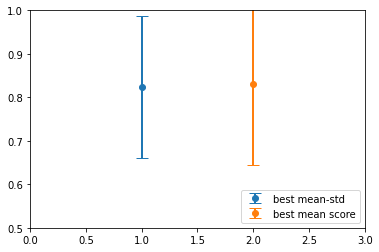

In [13]:
fig, ax = plt.subplots()
ax.errorbar([1], [0.824], yerr=[0.164], fmt='o', linewidth=2, capsize=6, label="best mean-std")
ax.errorbar([2], [0.831], yerr=[0.186], fmt='o', linewidth=2, capsize=6, label="best mean score")
ax.set(xlim=(0, 3), ylim=(0.5, 1));
ax.legend(loc="lower right");

    SMOTe after PCA

In [32]:
dtba_pipeline = PipelineImblearn(
    [
        ("scaler", RobustScaler()),
        ("pca", PCA()),
        ("smote", SMOTE(random_state=SEED, n_jobs=-1)),
        ("dt", DecisionTreeClassifier())
    ],
    memory="tmp"
)

dtba_gridsearch = GridSearchCV(dtba_pipeline, dtb_grid, **gargs, return_train_score=True)
dtba_gridsearch.fit(X, y);

Fitting 8 folds for each of 168 candidates, totalling 1344 fits


In [33]:
# choose best estimator: biggest score_mean - score_std
dtba_results = pd.DataFrame(dtba_gridsearch.cv_results_)
edit_df(dtba_results, classifier="dt", using_smote=True).head(7).round(3)

dt__ccp_alpha  c_weight tree:crit n_pc  \
118         0.001  balanced   entropy   22   
94         0.0001  balanced   entropy   22   
70          1e-05  balanced   entropy   22   
46          1e-06  balanced   entropy   22   
22              0  balanced   entropy   22   
91         0.0001  balanced   entropy   16   
79         0.0001  balanced      gini   16   

                                          oversampling  score_0  score_1  \
118  {'Bufonidae': 640, 'Dendrobatidae': 1000, 'Hyl...    0.624    0.855   
94   {'Bufonidae': 640, 'Dendrobatidae': 1000, 'Hyl...    0.623    0.859   
70   {'Bufonidae': 640, 'Dendrobatidae': 1000, 'Hyl...    0.622    0.865   
46   {'Bufonidae': 640, 'Dendrobatidae': 1000, 'Hyl...    0.605    0.856   
22   {'Bufonidae': 640, 'Dendrobatidae': 1000, 'Hyl...    0.603    0.864   
91   {'Bufonidae': 640, 'Dendrobatidae': 1000, 'Hyl...    0.561    0.862   
79   {'Bufonidae': 640, 'Dendrobatidae': 1000, 'Hyl...    0.545    0.869   

     score_2  score_3  score_4  score_5  score_6  score_7  score_m  score_s  \
118    0.898    0.900    0.923    0.955    0.981    0.693    0.854    0.119   
94     0.885    0.894    0.947    0.961    0.983    0.680    0.854    0.124   
70     0.888    0.896    0.936    0.961    0.998    0.676    0.855    0.126   
46     0.891    0.898    0.938    0.958    0.996    0.676    0.852    0.130   
22     0.886    0.899    0.939    0.966    0.981    0.671    0.851    0.130   
91     0.954    0.898    0.940    0.960    0.983    0.593    0.844    0.158   
79     0.912    0.900    0.934    0.974    0.973    0.602    0.838    0.157   

     rank  mean_train_score  std_train_score  score_*  
118     3             0.983            0.005    0.734  
94      2             1.000            0.000    0.730  
70      1             1.000            0.000    0.729  
46      4             1.000            0.000    0.722  
22      5             1.000            0.000    0.721  
91      9             1.000            0.000    0.686  
79     16             0.998            0.001    0.681

In [34]:
fig, ax = plt.subplots()
ax.errorbar([1], [0.854], yerr=[0.119], fmt='o', linewidth=2, capsize=6, label="best mean-std")
ax.errorbar([2], [0.855], yerr=[0.126], fmt='o', linewidth=2, capsize=6, label="best mean score")
ax.set(xlim=(0, 3), ylim=(0.5, 1));
ax.legend(loc="lower right");

    For the winning configuration, let's inspect the effect of alpha:

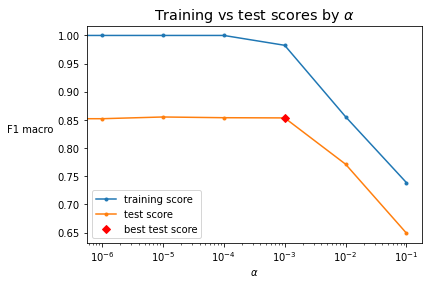

In [38]:
tmp = dtba_results.loc[(dtba_results["n_pc"]==22) & (dtba_results["tree:crit"]=="entropy") 
                       & (dtba_results["oversampling"]!="not majority")
                       & (dtba_results["oversampling"]!={"Bufonidae": 640})].sort_values("dt__ccp_alpha")
alphas = tmp["dt__ccp_alpha"]
test_scores = tmp["score_m"]
train_scores = tmp["mean_train_score"]

fig, ax = plt.subplots()

ax.plot(alphas, train_scores, marker=".", label="training score")
ax.plot(alphas, test_scores, marker=".", label="test score")
ax.plot([1e-3], [0.854], marker="D", label="best test score", linestyle="", color="red")

ax.set_title(r"Training vs test scores by $ \alpha $", fontsize="x-large")
ax.set_xlabel(r"$\alpha$")
ax.set_xscale("log")
ax.set_ylabel("F1 macro", rotation="horizontal", ha="right")
ax.legend()
plt.show()
fig.savefig("images/ccp.svg")

## Random Forest

    no rebalancing

In [18]:
rf_grid = {
    "pca__n_components": [8, 11, 16, 22],
    "rf__n_estimators": [50, 100, 150],
    "rf__criterion": ["gini", "entropy"],
    "rf__max_features": ["sqrt", 0.33],
    "rf__class_weight": ["balanced"],
}

rf_pipeline = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("pca", PCA()),
        ("rf", RandomForestClassifier(random_state=SEED, n_jobs=-1))
    ],
    memory="tmp"
)

rf_gridsearch = GridSearchCV(rf_pipeline, rf_grid, **gargs)
rf_gridsearch.fit(X, y);

Fitting 8 folds for each of 48 candidates, totalling 384 fits


In [19]:
# choose best estimator: biggest score_mean - score_std
rf_results = pd.DataFrame(rf_gridsearch.cv_results_)
edit_df(rf_results, classifier="rf").head(7).round(3)

n_pc  c_weight  rf:crit rf:max_f rf:n_trees  score_0  score_1  score_2  \
42   22  balanced  entropy     sqrt         50    0.598    0.885    0.992   
45   22  balanced  entropy     0.33         50    0.600    0.916    0.992   
43   22  balanced  entropy     sqrt        100    0.574    0.889    0.992   
44   22  balanced  entropy     sqrt        150    0.562    0.889    0.992   
38   22  balanced     gini     sqrt        150    0.559    0.911    0.989   
47   22  balanced  entropy     0.33        150    0.585    0.887    0.992   
46   22  balanced  entropy     0.33        100    0.583    0.893    0.990   

    score_3  score_4  score_5  score_6  score_7  score_m  score_s  rank  \
42    0.932    0.976    0.976    0.999    0.731    0.886    0.137     2   
45    0.925    0.977    0.974    0.999    0.713    0.887    0.139     1   
43    0.930    0.977    0.975    0.999    0.744    0.885    0.141     3   
44    0.933    0.977    0.974    0.999    0.747    0.884    0.144     4   
38    0.925    0.978    0.975    0.997    0.718    0.881    0.149     5   
47    0.925    0.977    0.991    0.997    0.686    0.880    0.148     9   
46    0.925    0.977    0.991    0.997    0.687    0.880    0.148     8   

    score_*  
42    0.749  
45    0.748  
43    0.744  
44    0.740  
38    0.733  
47    0.732  
46    0.732

    with SMOTe parameters

In [21]:
rfb_grid = {
    "smote__sampling_strategy": 
        [
            {"Bufonidae": 640},
            {"Bufonidae": 640, "Dendrobatidae": 1000, "Hylidae": 3000},
            "not majority"
        ],
    "pca__n_components": [8, 11, 16, 22],
    "rf__n_estimators": [50, 100, 150],
    "rf__criterion": ["gini", "entropy"],
    "rf__max_features": ["sqrt", 0.33],
    "rf__class_weight": ["balanced"],
}

    SMOTE before PCA 

In [22]:
rfbb_pipeline = PipelineImblearn(
    [
        ("smote", SMOTE(random_state=SEED, n_jobs=-1)),
        ("scaler", RobustScaler()),
        ("pca", PCA()),
        ("rf", RandomForestClassifier(random_state=SEED, n_jobs=-1))
    ],
    memory="tmp"
)

rfbb_gridsearch = GridSearchCV(rfbb_pipeline, rfb_grid, **gargs)
rfbb_gridsearch.fit(X, y);

Fitting 8 folds for each of 144 candidates, totalling 1152 fits


In [23]:
# choose best estimator: biggest score_mean - score_std
rfbb_results = pd.DataFrame(rfbb_gridsearch.cv_results_)
edit_df(rfbb_results, classifier="rf", using_smote=True).head(7).round(3)

n_pc  c_weight  rf:crit rf:max_f rf:n_trees        oversampling  score_0  \
134   22  balanced  entropy     sqrt        150        not majority    0.531   
135   22  balanced  entropy     0.33         50  {'Bufonidae': 640}    0.567   
108   22  balanced     gini     sqrt         50  {'Bufonidae': 640}    0.551   
131   22  balanced  entropy     sqrt        100        not majority    0.517   
116   22  balanced     gini     sqrt        150        not majority    0.521   
110   22  balanced     gini     sqrt         50        not majority    0.517   
90    16  balanced  entropy     sqrt         50  {'Bufonidae': 640}    0.534   

     score_1  score_2  score_3  score_4  score_5  score_6  score_7  score_m  \
134    0.919    0.994    0.932    0.976    0.996    0.999    0.727    0.884   
135    0.923    0.990    0.928    0.975    0.991    0.999    0.668    0.880   
108    0.916    0.986    0.930    0.976    0.986    1.000    0.683    0.879   
131    0.919    0.996    0.955    0.976    0.996    0.999    0.720    0.885   
116    0.917    0.996    0.932    0.976    0.983    0.999    0.719    0.880   
110    0.914    0.999    0.932    0.975    0.983    0.999    0.725    0.880   
90     0.922    0.985    0.926    0.975    0.994    0.999    0.693    0.878   

     score_s  rank  score_*  
134    0.158     2    0.726  
135    0.156     7    0.724  
108    0.157    10    0.721  
131    0.164     1    0.721  
116    0.161     6    0.720  
110    0.161     5    0.719  
90     0.160    11    0.718

In [24]:
fig, ax = plt.subplots()
ax.errorbar([1], [0.884], yerr=[0.158], fmt='o', linewidth=2, capsize=6, label="best mean-std")
ax.errorbar([2], [0.885], yerr=[0.164], fmt='o', linewidth=2, capsize=6, label="best mean score")
ax.set(xlim=(0, 3), ylim=(0.5, 1));
ax.legend(loc="lower right");

    SMOTE after PCA 

In [25]:
rfba_pipeline = PipelineImblearn(
    [
        ("scaler", RobustScaler()),
        ("pca", PCA()),
        ("smote", SMOTE(random_state=SEED, n_jobs=-1)),
        ("rf", RandomForestClassifier(random_state=SEED, n_jobs=-1))
    ],
    memory="tmp"
)

rfba_gridsearch = GridSearchCV(rfba_pipeline, rfb_grid, **gargs)
rfba_gridsearch.fit(X, y);

Fitting 8 folds for each of 144 candidates, totalling 1152 fits


In [26]:
# choose best estimator: biggest score_mean - score_std
rfba_results = pd.DataFrame(rfba_gridsearch.cv_results_)
edit_df(rfba_results, classifier="rf", using_smote=True).head(7).round(3)

n_pc  c_weight  rf:crit rf:max_f rf:n_trees  \
116   22  balanced     gini     sqrt        150   
134   22  balanced  entropy     sqrt        150   
114   22  balanced     gini     sqrt        150   
88    16  balanced     gini     0.33        150   
119   22  balanced     gini     0.33         50   
133   22  balanced  entropy     sqrt        150   
121   22  balanced     gini     0.33        100   

                                          oversampling  score_0  score_1  \
116                                       not majority    0.643    0.923   
134                                       not majority    0.626    0.924   
114                                 {'Bufonidae': 640}    0.617    0.915   
88   {'Bufonidae': 640, 'Dendrobatidae': 1000, 'Hyl...    0.623    0.914   
119                                       not majority    0.622    0.926   
133  {'Bufonidae': 640, 'Dendrobatidae': 1000, 'Hyl...    0.601    0.913   
121  {'Bufonidae': 640, 'Dendrobatidae': 1000, 'Hyl...    0.633    0.918   

     score_2  score_3  score_4  score_5  score_6  score_7  score_m  score_s  \
116    0.995    0.930    0.977    0.991    1.000    0.666    0.891    0.139   
134    0.995    0.933    0.978    0.994    1.000    0.648    0.887    0.147   
114    0.990    0.923    0.977    0.991    0.997    0.664    0.884    0.144   
88     0.993    0.925    0.974    0.990    0.999    0.657    0.885    0.144   
119    0.993    0.922    0.977    0.987    0.999    0.655    0.885    0.145   
133    0.992    0.925    0.977    0.992    1.000    0.681    0.885    0.145   
121    0.994    0.925    0.974    0.989    0.999    0.641    0.884    0.146   

     rank  score_*  
116     1    0.751  
134     2    0.740  
114    13    0.740  
88     11    0.740  
119     7    0.740  
133     8    0.740  
121    14    0.739

## SVM

In [42]:
X = np.ascontiguousarray(df.drop(columns="Family"), dtype=np.double)  # required for SVM optimization

In [43]:
svm_grid = {
    "pca__n_components": [8, 11, 16, 22],
    "svc__C" : [1e-2, 1e-1, 1, 1e1, 1e2],
    "svc__gamma" : [1e-2, 1e-1, 1, None, 1e2],
    "svc__kernel": ["rbf"],
    "svc__class_weight": ["balanced"],
}

svm_pipeline = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("pca", PCA()),
        ("svc", SVC(cache_size=2000))  # Kernel cache size 
    ],
    memory="tmp"
)

svm_gridsearch = GridSearchCV(svm_pipeline, svm_grid, **gargs)
svm_gridsearch.fit(X, y)

Fitting 8 folds for each of 100 candidates, totalling 800 fits


KeyboardInterrupt: 

In [41]:
# choose best estimator: biggest score_mean - score_std
svm_results = pd.DataFrame(svm_gridsearch.cv_results_)
edit_df(svm_results, classifier="svm").head(7).round(3)

n_pc svc__C svc__class_weight svc__gamma svc__kernel  score_0  score_1  \
66   16     10          balanced        0.1         rbf    0.574    0.935   
17    8     10          balanced          1         rbf    0.536    0.886   
22    8    100          balanced          1         rbf    0.536    0.886   
91   22     10          balanced        0.1         rbf    0.564    0.935   
32   11    0.1          balanced          1         rbf    0.540    0.868   
71   16    100          balanced        0.1         rbf    0.576    0.934   
12    8      1          balanced          1         rbf    0.531    0.885   

    score_2  score_3  score_4  score_5  score_6  score_7  score_m  score_s  \
66    0.985    0.936    0.990    0.999    1.000    0.649    0.884    0.160   
17    0.976    0.918    0.963    0.990    0.998    0.731    0.875    0.152   
22    0.976    0.918    0.963    0.990    0.998    0.731    0.875    0.152   
91    0.985    0.937    0.991    1.000    1.000    0.655    0.883    0.162   
32    0.978    0.887    0.932    0.949    0.994    0.754    0.863    0.141   
71    0.976    0.920    0.988    0.999    1.000    0.646    0.880    0.159   
12    0.980    0.914    0.962    0.989    0.998    0.728    0.873    0.153   

    rank  score_*  
66     1    0.724  
17     7    0.723  
22     7    0.723  
91     2    0.722  
32    18    0.722  
71     4    0.721  
12     9    0.720

    SVC & Rebalancing

In [19]:
svmb_grid = {
    "smote__sampling_strategy": 
        [
            {"Bufonidae": 640},
            {"Bufonidae": 640, "Dendrobatidae": 1000, "Hylidae": 3000},
            "not majority"
        ],
    "pca__n_components": [11, 16, 22],
    "svc__C" : [1e-2, 1e-1, 1, 1e1, 1e2],
    "svc__gamma" : [1e-2, 1e-1, 1, 1e1, 1e2],
    "svc__kernel": ["rbf"],
    "svc__class_weight": ["balanced"],
}

    SMOTE before PCA

In [21]:
svmbb_pipeline = PipelineImblearn(
    [
        ("smote", SMOTE()),
        ("scaler", RobustScaler()),
        ("pca", PCA()),
        ("svc", SVC(cache_size=2000))  # Kernel cache size 
    ],
    memory="tmp"
)

svmbb_gridsearch = GridSearchCV(svmbb_pipeline, svmb_grid, **gargs)
svmbb_gridsearch.fit(X, y)

Fitting 8 folds for each of 225 candidates, totalling 1800 fits


KeyboardInterrupt: 

In [ ]:
svmba_pipeline = PipelineImblearn(
    [
        ("scaler", RobustScaler()),
        ("pca", PCA()),
        ("smote", SMOTE()),
        ("svc", SVC(cache_size=4000))  # Kernel cache size 
    ],
    memory="tmp"
)

svmba_gridsearch = GridSearchCV(svmba_pipeline, svmb_grid, **gargs)
svmba_gridsearch.fit(X, y)

In [ ]:
# choose best estimator: biggest score_mean - score_std
svmba_results = pd.DataFrame(svmba_gridsearch.cv_results_)
edit_df(svmba_results, classifier="svm", using_smote=True).head(10).round(3)

## AdaBoost

    without rebalancing

In [66]:
ada_grid = [
    {
        "pca__n_components": [8, 11, 16, 22],
        "ada__base_estimator": [DecisionTreeClassifier(max_depth=1)],
        "ada__n_estimators": [250, 500]
    },
    {
        "pca__n_components": [8, 11, 16, 22],
        "ada__base_estimator": [DecisionTreeClassifier(max_depth=2)],
        "ada__n_estimators": [125, 250, 500]
    },
    {
        "pca__n_components": [8, 11, 16, 22],
        "ada__base_estimator": [DecisionTreeClassifier(max_depth=3)],
        "ada__n_estimators": [65, 125, 250, 500]
    }
]

ada_pipeline = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("pca", PCA()),
        ("ada", AdaBoostClassifier(random_state=SEED))
    ])

ada_gridsearch = GridSearchCV(ada_pipeline, ada_grid, **gargs, return_train_score=True)
ada_gridsearch.fit(X, y)

Fitting 8 folds for each of 36 candidates, totalling 288 fits


GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('pca', PCA()),
                                       ('ada',
                                        AdaBoostClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'ada__base_estimator': [DecisionTreeClassifier(max_depth=1)],
                          'ada__n_estimators': [250, 500],
                          'pca__n_components': [8, 11, 16, 22]},
                         {'ada__base_estimator': [DecisionTreeClassifier(max_depth=2)],
                          'ada__n_estimators': [125, 250, 500],
                          'pca__n_components': [8, 11, 16, 22]},
                         {'ada__base_estimator': [DecisionTreeClassifier(max_depth=3)],
                          'ada__n_estimators': [65, 125, 250, 500],
                          'pca__n_components': [8, 11, 16, 22]}],
             return_train_score=True, scoring='f1_macro',

In [67]:
# choose best estimator: biggest score_mean - score_std
ada_results = pd.DataFrame(ada_gridsearch.cv_results_)
edit_df(ada_results, classifier="ada").head(10).round(3)

ada__base_estimator ada__n_estimators n_pc  score_0  \
34  DecisionTreeClassifier(max_depth=3)               500   16    0.570   
15  DecisionTreeClassifier(max_depth=2)               250   22    0.585   
35  DecisionTreeClassifier(max_depth=3)               500   22    0.542   
27  DecisionTreeClassifier(max_depth=3)               125   22    0.567   
24  DecisionTreeClassifier(max_depth=3)               125    8    0.623   
30  DecisionTreeClassifier(max_depth=3)               250   16    0.548   
31  DecisionTreeClassifier(max_depth=3)               250   22    0.540   
19  DecisionTreeClassifier(max_depth=2)               500   22    0.552   
33  DecisionTreeClassifier(max_depth=3)               500   11    0.602   
18  DecisionTreeClassifier(max_depth=2)               500   16    0.558   

    score_1  score_2  score_3  score_4  score_5  score_6  score_7  score_m  \
34    0.889    0.982    0.923    0.963    0.966    0.998    0.706    0.875   
15    0.873    0.946    0.895    0.923    0.944    0.969    0.712    0.856   
35    0.892    0.972    0.921    0.971    0.973    0.999    0.719    0.874   
27    0.848    0.972    0.913    0.964    0.971    0.996    0.702    0.867   
24    0.883    0.941    0.881    0.933    0.940    0.999    0.639    0.855   
30    0.878    0.978    0.923    0.962    0.960    0.999    0.709    0.870   
31    0.890    0.965    0.918    0.967    0.965    0.999    0.707    0.869   
19    0.881    0.979    0.905    0.921    0.948    0.991    0.703    0.860   
33    0.864    0.966    0.911    0.939    0.959    0.999    0.633    0.859   
18    0.867    0.963    0.895    0.878    0.939    0.977    0.686    0.845   

    score_s  rank  mean_train_score  std_train_score  score_*  
34    0.144     1             0.993            0.003    0.730  
15    0.127     9             0.956            0.016    0.729  
35    0.151     2             0.995            0.002    0.723  
27    0.145     5             0.988            0.005    0.722  
24    0.134    10             0.974            0.013    0.721  
30    0.149     3             0.989            0.005    0.721  
31    0.151     4             0.992            0.004    0.718  
19    0.144     6             0.965            0.013    0.716  
33    0.145     7             0.988            0.005    0.715  
18    0.138    16             0.953            0.017    0.707

    SMOTe

In [68]:
adab_grid = [
    {
        "smote__sampling_strategy": 
        [
            {"Bufonidae": 640},
            {"Bufonidae": 640, "Dendrobatidae": 1000, "Hylidae": 3000},
            "not majority"
        ],
        "pca__n_components": [8, 11, 16, 22],
        "ada__base_estimator": [DecisionTreeClassifier(max_depth=1)],
        "ada__n_estimators": [500, 750]
    },
    {
        "smote__sampling_strategy": 
        [
            {"Bufonidae": 640},
            {"Bufonidae": 640, "Dendrobatidae": 1000, "Hylidae": 3000},
            "not majority"
        ],
        "pca__n_components": [8, 11, 16, 22],
        "ada__base_estimator": [DecisionTreeClassifier(max_depth=2)],
        "ada__n_estimators": [125, 250, 500]
    },
    {
        "smote__sampling_strategy": 
        [
            {"Bufonidae": 640},
            {"Bufonidae": 640, "Dendrobatidae": 1000, "Hylidae": 3000},
            "not majority"
        ],
        "pca__n_components": [8, 11, 16, 22],
        "ada__base_estimator": [DecisionTreeClassifier(max_depth=3)],
        "ada__n_estimators": [65, 125, 250, 500]
    }
]

    SMOTe before PCA

In [69]:
adabb_pipeline = PipelineImblearn(
    [
        ("smote", SMOTE(random_state=SEED, n_jobs=-1)),
        ("scaler", RobustScaler()),
        ("pca", PCA()),
        ("ada", AdaBoostClassifier(random_state=SEED))
    ])

adabb_gridsearch = GridSearchCV(adabb_pipeline, adab_grid, **gargs, return_train_score=True)
adabb_gridsearch.fit(X, y)

Fitting 8 folds for each of 108 candidates, totalling 864 fits


GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(n_jobs=-1, random_state=42)),
                                       ('scaler', RobustScaler()),
                                       ('pca', PCA()),
                                       ('ada',
                                        AdaBoostClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'ada__base_estimator': [DecisionTreeClassifier(max_depth=1)],
                          'ada__n_estimators': [500, 750],
                          'pca__n_components': [8, 11, 16, 22],
                          'smote__sampling_strategy': [{'B...
                                                        'Dendrobatidae': 1000,
                                                        'Hylidae': 3000},
                                                       'not majority']},
                         {'ada__base_estimator': [DecisionTreeClassifier(max_depth=3

In [76]:
# choose best estimator: biggest score_mean - score_std
adabb_results = pd.DataFrame(adabb_gridsearch.cv_results_)
edit_df(adabb_results, classifier="ada", using_smote=True).head(10).round(3)

ada__base_estimator ada__n_estimators n_pc  \
71   DecisionTreeClassifier(max_depth=3)                65   22   
107  DecisionTreeClassifier(max_depth=3)               500   22   
59   DecisionTreeClassifier(max_depth=2)               500   22   
104  DecisionTreeClassifier(max_depth=3)               500   16   
95   DecisionTreeClassifier(max_depth=3)               250   22   
102  DecisionTreeClassifier(max_depth=3)               500   16   
105  DecisionTreeClassifier(max_depth=3)               500   22   
83   DecisionTreeClassifier(max_depth=3)               125   22   
93   DecisionTreeClassifier(max_depth=3)               250   22   
57   DecisionTreeClassifier(max_depth=2)               500   22   

           oversampling  score_0  score_1  score_2  score_3  score_4  score_5  \
71         not majority    0.619    0.901    0.941    0.877    0.931    0.972   
107        not majority    0.598    0.926    0.981    0.941    0.968    0.983   
59         not majority    0.609    0.914    0.966    0.946    0.920    0.954   
104        not majority    0.575    0.927    0.981    0.969    0.963    0.988   
95         not majority    0.600    0.923    0.978    0.939    0.966    0.981   
102  {'Bufonidae': 640}    0.618    0.907    0.980    0.923    0.951    0.964   
105  {'Bufonidae': 640}    0.587    0.904    0.968    0.915    0.957    0.965   
83         not majority    0.572    0.892    0.966    0.921    0.956    0.987   
93   {'Bufonidae': 640}    0.590    0.896    0.962    0.917    0.951    0.959   
57   {'Bufonidae': 640}    0.625    0.860    0.937    0.929    0.918    0.950   

     score_6  score_7  score_m  score_s  rank  mean_train_score  \
71     0.961    0.778    0.873    0.112    15             0.959   
107    0.999    0.746    0.892    0.134     2             0.994   
59     0.970    0.749    0.879    0.122     8             0.929   
104    0.996    0.769    0.896    0.139     1             0.992   
95     0.999    0.738    0.890    0.134     3             0.991   
102    0.998    0.713    0.882    0.130     7             0.991   
105    0.998    0.759    0.882    0.131     6             0.992   
83     0.998    0.787    0.885    0.134     5             0.983   
93     0.997    0.752    0.878    0.129     9             0.988   
57     0.984    0.728    0.866    0.117    22             0.960   

     std_train_score  score_*  
71             0.025    0.761  
107            0.002    0.758  
59             0.068    0.757  
104            0.003    0.757  
95             0.004    0.756  
102            0.003    0.752  
105            0.004    0.751  
83             0.007    0.751  
93             0.006    0.749  
57             0.015    0.749

In [91]:
tmp = adabb_results[
    (adabb_results["oversampling"] == "not majority") &
    (adabb_results["n_pc"] == 16)
]
tmp = tmp.loc[[104, 92, 80, 68]].sort_values("ada__n_estimators")
tmp

ada__base_estimator ada__n_estimators n_pc  oversampling  \
68   DecisionTreeClassifier(max_depth=3)                65   16  not majority   
80   DecisionTreeClassifier(max_depth=3)               125   16  not majority   
92   DecisionTreeClassifier(max_depth=3)               250   16  not majority   
104  DecisionTreeClassifier(max_depth=3)               500   16  not majority   

      score_0   score_1   score_2   score_3   score_4   score_5   score_6  \
68   0.526642  0.911737  0.973146  0.916476  0.966209  0.902575  0.969513   
80   0.531667  0.918111  0.967972  0.955725  0.970360  0.918234  0.991239   
92   0.574978  0.926424  0.974082  0.968607  0.947223  0.983716  0.994320   
104  0.575334  0.927125  0.980699  0.969054  0.962786  0.987829  0.995714   

      score_7   score_m   score_s  rank  mean_train_score  std_train_score  \
68   0.769291  0.866949  0.142620    21          0.962944         0.032260   
80   0.759990  0.876662  0.146874    11          0.982839         0.007417   
92   0.743179  0.889066  0.140670     4          0.989698         0.004271   
104  0.769286  0.895978  0.139283     1          0.991930         0.003294   

      score_*  
68   0.724329  
80   0.729788  
92   0.748397  
104  0.756695

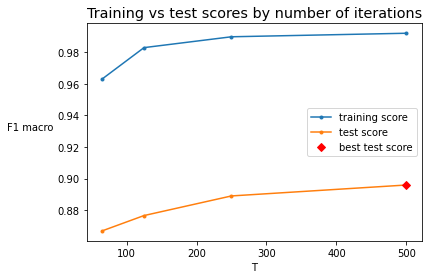

In [103]:
n_iterations = tmp["ada__n_estimators"]
test_scores = tmp["score_m"]
train_scores = tmp["mean_train_score"]

fig, ax = plt.subplots()

ax.plot(n_iterations, train_scores, marker=".", label="training score")
ax.plot(n_iterations, test_scores, marker=".", label="test score")
ax.plot([500], [0.896], marker="D", label="best test score", linestyle="", color="red")

ax.set_title("Training vs test scores by number of iterations", fontsize="x-large")
ax.set_xlabel("T")
ax.set_ylabel("F1 macro", rotation="horizontal", ha="right")
ax.legend()
plt.show()
fig.savefig("images/adaBoost.svg")

    SMOTe after PCA

In [98]:
adaba_pipeline = PipelineImblearn(
    [
        ("scaler", RobustScaler()),
        ("pca", PCA()),
        ("smote", SMOTE(random_state=SEED, n_jobs=-1)),
        ("ada", AdaBoostClassifier(random_state=SEED))
    ])

adaba_gridsearch = GridSearchCV(adaba_pipeline, adab_grid, **gargs, return_train_score=True)
adaba_gridsearch.fit(X, y)

Fitting 8 folds for each of 108 candidates, totalling 864 fits


GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('pca', PCA()),
                                       ('smote',
                                        SMOTE(n_jobs=-1, random_state=42)),
                                       ('ada',
                                        AdaBoostClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'ada__base_estimator': [DecisionTreeClassifier(max_depth=1)],
                          'ada__n_estimators': [500, 750],
                          'pca__n_components': [8, 11, 16, 22],
                          'smote__sampling_strategy': [{'B...
                                                        'Dendrobatidae': 1000,
                                                        'Hylidae': 3000},
                                                       'not majority']},
                         {'ada__base_estimator': [DecisionTreeClassifier(max_depth=3

In [101]:
# choose best estimator: biggest score_mean - score_std
adaba_results = pd.DataFrame(adaba_gridsearch.cv_results_)
edit_df(adaba_results, classifier="ada").head(5).round(3)

ada__base_estimator ada__n_estimators n_pc  \
93   DecisionTreeClassifier(max_depth=3)               250   22   
71   DecisionTreeClassifier(max_depth=3)                65   22   
106  DecisionTreeClassifier(max_depth=3)               500   22   
105  DecisionTreeClassifier(max_depth=3)               500   22   
107  DecisionTreeClassifier(max_depth=3)               500   22   

                              smote__sampling_strategy  score_0  score_1  \
93                                  {'Bufonidae': 640}    0.622    0.886   
71                                        not majority    0.633    0.852   
106  {'Bufonidae': 640, 'Dendrobatidae': 1000, 'Hyl...    0.591    0.891   
105                                 {'Bufonidae': 640}    0.592    0.889   
107                                       not majority    0.596    0.888   

     score_2  score_3  score_4  score_5  score_6  score_7  score_m  score_s  \
93     0.977    0.910    0.946    0.943    0.995    0.672    0.869    0.133   
71     0.963    0.904    0.912    0.973    0.988    0.677    0.863    0.127   
106    0.982    0.918    0.971    0.967    0.999    0.693    0.877    0.142   
105    0.984    0.918    0.965    0.965    0.996    0.682    0.874    0.142   
107    0.988    0.912    0.965    0.971    1.000    0.678    0.875    0.143   

     rank  mean_train_score  std_train_score  score_*  
93      7             0.991            0.004    0.736  
71     15             0.966            0.017    0.736  
106     1             0.993            0.003    0.735  
105     3             0.994            0.003    0.732  
107     2             0.991            0.004    0.732

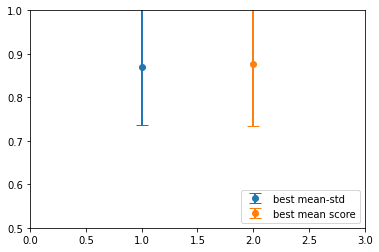

In [102]:
fig, ax = plt.subplots()
ax.errorbar([1], [0.869], yerr=[0.133], fmt='o', linewidth=2, capsize=6, label="best mean-std")
ax.errorbar([2], [0.877], yerr=[0.142], fmt='o', linewidth=2, capsize=6, label="best mean score")
ax.set(xlim=(0, 3), ylim=(0.5, 1));
ax.legend(loc="lower right");

    Score comparisson

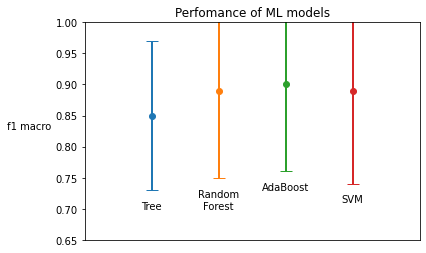

In [164]:
fig, ax = plt.subplots()
ax.errorbar([1], [0.85], yerr=[0.12], fmt='o', linewidth=2, capsize=6, label="Decision Tree")
ax.errorbar([2], [0.89], yerr=[0.14], fmt='o', linewidth=2, capsize=6, label="Random Forest")
ax.errorbar([3], [0.90], yerr=[0.14], fmt='o', linewidth=2, capsize=6, label="AdaBoost")
ax.errorbar([4], [0.89], yerr=[0.15], fmt='o', linewidth=2, capsize=6, label="SVM")

ax.annotate("Tree", (1,0.85), xytext=(1,0.7), ha="center", color="k") 
ax.annotate("Random\nForest", (2,0.89), xytext=(2,0.7), ha="center", color="k") 
ax.annotate("AdaBoost", (3,0.90), xytext=(3,0.73), ha="center", color="k") 
ax.annotate("SVM", (4,0.89), xytext=(4,0.71), ha="center", color="k") 


ax.set(xlim=(0, 5), xticks=[], ylim=(0.65, 1));
ax.set_ylabel("f1 macro", rotation="horizontal", ha="right")
ax.set_title("Perfomance of ML models");
fig.savefig("images/model_performance.svg")

In [167]:
best_model = adabb_gridsearch.best_estimator_
y_pred = cross_val_predict(best_model, X, y, cv=8, n_jobs=-1)

In [169]:
cf_matrix = confusion_matrix(y, y_pred)

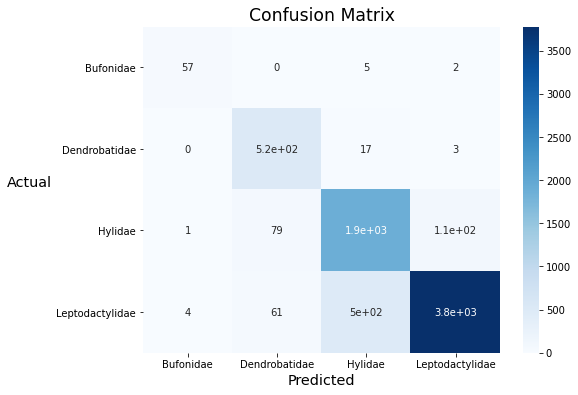

In [213]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cf_matrix, annot=True, cmap="Blues", ax=ax)
ax.set_xticklabels(["Bufonidae","Dendrobatidae", "Hylidae", "Leptodactylidae"])
ax.set_xlabel("Predicted", va="top", fontsize="x-large")
ax.set_yticklabels(["Bufonidae","Dendrobatidae", "Hylidae", "Leptodactylidae"], rotation="horizontal")
ax.set_ylabel("Actual", rotation="horizontal", ha="right", fontsize="x-large")
ax.set_title("Confusion Matrix", fontsize="xx-large")
fig.savefig("images/confusion_matrix.svg")